In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import numpy as np
import random

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

# infile = "run_agree_interact_common_20_061619_prod_2_4.npz"
# het_infile = "run_agree_interact_common_20_061619_prod_2_10.npz"
or_infile = "run_orfunc_common_20_061420_9_same_1_diff.npz"
het_infile = "run_agree_interact_common_20_061420_prod_1_9_same_1_diff_5_test.npz"
#outfile = "../../data/balanced_adult_matched_pairs/balanced_adult_matched_pairs.npz"

random.seed(0)
data = np.load(het_infile)

In [25]:
# study_1 = data["x_train"][:5000]
# study_2 = data["x_train"][45000:]

# dup = np.tile(study_2, (9,1))
# data_x_train = np.concatenate((dup, study_1), axis=0)
# data_x_train.shape



In [26]:
# study_1 = data["y_train"][:5000]
# study_2 = data["y_train"][45000:]
# dup = np.tile(study_2, (9, 1))
# data_y_train = np.concatenate((dup, study_1), axis=0)
# data_y_train.shape

In [27]:
x_train = data['x_train'][data['train_inds']]
y_train = data['y_train'][data['train_inds']][:,1]
attr_train = data['attr_train'][data['train_inds']]

x_valid = data['x_train'][data['valid_inds']]
y_valid = data['y_train'][data['valid_inds']][:,1]
attr_valid = data['attr_train'][data['valid_inds']]

x_test = data['x_test']
y_test = data['y_test'][:,1]
attr_test = data['attr_test']

In [28]:
# nk = np.ones(15)*5000
# ind = np.repeat(0, nk[0])
# for i in range(1, 5):
#     ind = np.concatenate((ind, np.repeat(i, nk[i])), axis=0)
# attr_test = np.zeros((ind.size, 10))
# attr_test[np.arange(ind.size), ind] = 1

In [29]:
attr_test[2500]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [30]:
data['x_train'].shape

(50000, 30)

In [31]:
y_train = y_train.reshape(y_train.shape[0], 1)
y_valid = y_valid.reshape(y_valid.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

In [32]:
# planning
# want to train a classifier f which minimizes loss of max over domain i of avg [L(f_i(x), y) for all x in domain i]
# f is regular feed-forward MLP with 2 hidden layers, input dim 30, output dim 1

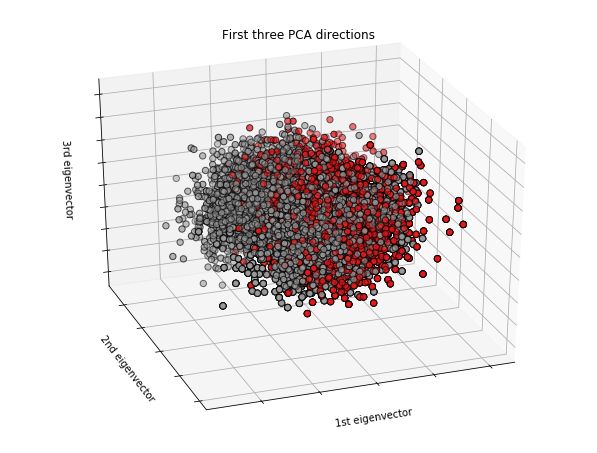

In [33]:
# plot the first 3 PCA dimensions of the sampled data
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(x_train)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_train.ravel(),
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
plt.show()

In [34]:
# create the TF neural net
# some hyperparams
training_epochs = 50

# n_neurons_in_h1 = 2
# n_neurons_in_h2 = 2
# learning_rate = 0.001

n_features = len(x_train[0])
labels_dim = 1
attr_dim = attr_train.shape[1]
attr_dim

10

In [35]:
def compute_avg_loss(labels, logits):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits))

In [36]:
def compute_avg_loss_plus_var(labels, logits, coeff=1.0):
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
    avg_loss = tf.reduce_mean(cross_entropy)
    var = tf.math.reduce_std(cross_entropy)
    return avg_loss + 1.0*var

In [119]:
def compute_avg_loss_plus_domain_var(labels, logits, coeff=0.1, study_ids=None):
    avg_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits))
    
    avg_losses = []
    for i in range(10):
        study_mask = study_ids[:,i]
        study_labels = tf.boolean_mask(labels, study_mask)
        study_logits = tf.boolean_mask(logits, study_mask)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = study_labels, logits = study_logits)
        avg_losses.append(tf.reduce_mean(loss))
    domain_var = tf.math.reduce_std(avg_losses)
    return tf.math.add(avg_loss, tf.math.multiply(tf.cast(coeff, dtype='float32'), tf.cast(domain_var, dtype='float32')))

In [120]:
def compute_loss_10(labels, logits, study_ids):
    # labels = truth, logits = f(x)
    study_mask = study_ids[:,0]
    study_labels = tf.boolean_mask(labels, study_mask)
    study_logits = tf.boolean_mask(logits, study_mask)
    loss0 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = study_labels, logits = study_logits))

    study_mask = study_ids[:,1]
    study_labels = tf.boolean_mask(labels, study_mask)
    study_logits = tf.boolean_mask(logits, study_mask)
    loss1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = study_labels, logits = study_logits))
    
    study_mask = study_ids[:,2]
    study_labels = tf.boolean_mask(labels, study_mask)
    study_logits = tf.boolean_mask(logits, study_mask)
    loss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = study_labels, logits = study_logits))

    study_mask = study_ids[:,3]
    study_labels = tf.boolean_mask(labels, study_mask)
    study_logits = tf.boolean_mask(logits, study_mask)
    loss3 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = study_labels, logits = study_logits))

    study_mask = study_ids[:,4]
    study_labels = tf.boolean_mask(labels, study_mask)
    study_logits = tf.boolean_mask(logits, study_mask)
    loss4 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = study_labels, logits = study_logits))

    study_mask = study_ids[:,5]
    study_labels = tf.boolean_mask(labels, study_mask)
    study_logits = tf.boolean_mask(logits, study_mask)
    loss5 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = study_labels, logits = study_logits))

    study_mask = study_ids[:,6]
    study_labels = tf.boolean_mask(labels, study_mask)
    study_logits = tf.boolean_mask(logits, study_mask)
    loss6 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = study_labels, logits = study_logits))

    study_mask = study_ids[:,7]
    study_labels = tf.boolean_mask(labels, study_mask)
    study_logits = tf.boolean_mask(logits, study_mask)
    loss7 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = study_labels, logits = study_logits))

    study_mask = study_ids[:,8]
    study_labels = tf.boolean_mask(labels, study_mask)
    study_logits = tf.boolean_mask(logits, study_mask)
    loss8 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = study_labels, logits = study_logits))

    study_mask = study_ids[:,9]
    study_labels = tf.boolean_mask(labels, study_mask)
    study_logits = tf.boolean_mask(logits, study_mask)
    loss9 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = study_labels, logits = study_logits))

#     avg_losses = tf.stack([loss0, loss8, loss9])
    avg_losses = tf.stack([loss0, loss1, loss2, loss3, loss4, loss5, loss6, loss7, loss8, loss9])
    return tf.reduce_max(avg_losses)

#     avg_losses = []
#     for i in range(10):
#         study_mask = study_ids[:,i]
#         study_labels = tf.boolean_mask(labels, study_mask)
#         study_logits = tf.boolean_mask(logits, study_mask)
#         loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = study_labels, logits = study_logits)
#         avg_losses.append(tf.reduce_mean(loss))
#     return tf.reduce_max(avg_losses)

In [121]:
sample_y = tf.constant(y_train[:50])
sample_logits = tf.constant(np.random.random(50).reshape((50, 1)))
sample_a = tf.constant(attr_train[:50])
# print(sample_y.eval(session=tf.Session()))

In [122]:
# print(compute_loss_10(sample_y, sample_logits, sample_a, False).eval(session=tf.Session()))
print(compute_avg_loss_plus_domain_var(sample_y, sample_logits, coeff=0.1, study_ids=sample_a).eval(session=tf.Session()))

TypeError: Input 'y' of 'Add' Op has type float32 that does not match type float64 of argument 'x'.

In [ ]:
sample_y.shape[0].value
print(sample_a[0])
a = tf.constant([[0., 1.],[0., 1.]])
b = tf.constant([0., 1.])
a_1 = a[:,1]
filter_1 = tf.boolean_mask(sample_y[:2], 1.-a_1)
print(filter_1.eval(session=tf.Session()))
# tf.reduce_all(tf.math.equal(a, b)).eval(session=tf.Session())

In [ ]:
mean = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = sample_y, logits = sample_logits))
print(mean.eval(session=tf.Session()))


In [ ]:
def get_data_from_domain(data, study_ids, domain): # domain between 0 and attr_dim-1
    study_mask = study_ids[:, domain] == 1.
    return data[study_mask]

In [123]:
def get_train_batch_from_each_domain(batch_num, batch_size=5): # domain between 0 and attr_dim-1
    start = batch_num*batch_size
    end = min(len(x_train), (batch_num+1)*batch_size)
    num_studies = attr_train.shape[1]
    x_batch = None
    y_batch = None
    z_batch = None

    for domain in range(num_studies):
        study_mask = attr_train[:, domain] == 1.
        x_study_batch = x_train[study_mask][start:end]
        y_study_batch = y_train[study_mask][start:end]
        attr_study_batch = attr_train[study_mask][start:end]
        if domain == 0:
            x_batch = x_study_batch
            y_batch = y_study_batch
            attr_batch = attr_study_batch
        else:
            x_batch = np.concatenate((x_batch, x_study_batch), axis=0)
            y_batch = np.concatenate((y_batch, y_study_batch), axis=0)
            attr_batch = np.concatenate((attr_batch, attr_study_batch), axis=0)
    arr = np.arange(x_batch.shape[0])
    np.random.shuffle(arr)
    np.take(x_batch,arr,axis=0,out=x_batch)
    np.take(y_batch,arr,axis=0,out=y_batch)
    np.take(attr_batch,arr,axis=0,out=attr_batch)
    return x_batch, y_batch, attr_batch

In [124]:
get_train_batch_from_each_domain(1)[2].shape

(50, 10)

In [125]:
x_test[0]

array([-0.21758162, -5.54948001,  3.95802967,  0.72904227, -3.2322578 ,
        4.61219557, -0.71614761,  5.14493289,  1.33197976,  2.40294122,
        3.94172396,  6.14069198, -6.55134302, -1.76202628, -2.50917197,
       -3.63252995, -0.52091884, -0.69812576, -0.35137775,  6.06676912,
        6.43400078,  0.50817979,  2.72505169, -1.19167835, -4.06174485,
       -1.06524935, -3.21238991,  0.58080082, -3.96871179,  6.40948181])

In [126]:
get_data_from_domain(x_test, attr_test, 0)

array([[-0.21758162, -5.54948001,  3.95802967, ...,  0.58080082,
        -3.96871179,  6.40948181],
       [-3.69318584,  0.21332461,  5.17443867, ...,  4.00251485,
         2.5173006 ,  0.44652525],
       [-4.92168566, -3.08192211,  1.27627984, ...,  4.9615979 ,
         1.53912614, -2.0835957 ],
       ...,
       [-8.15920622,  0.03244008, -0.73468327, ..., -1.85817595,
         4.44559342, -2.92166208],
       [ 1.78072944,  0.41237135,  3.45647094, ...,  1.1125281 ,
         3.21177752, -0.64800583],
       [ 2.65114675, -6.84370513,  1.65081029, ...,  2.67229731,
        -2.50776515,  1.05288845]])

In [127]:
# losses = []
# for index in range(attr_dim):
#     study_labels = []
#     study_logits = []
#     study = np.zeros(attr_dim)
#     study[index] = 1.0
#     study = tf.constant(study)
    
#     for i in range(sample_a.shape[0].value):
#         if tf.reduce_all(tf.math.equal(sample_a[i], study)).eval(session=tf.Session()):
#             study_labels.append(sample_y[i])
#             study_logits.append(sample_logits[i])
#     study_labels = np.asarray(study_labels)
#     study_logits = np.asarray(study_logits)
#     study_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = study_labels, logits = study_logits))
#     losses.append(study_loss)
# max_loss = tf.reduce_max(losses)
# print(max_loss.eval(session=tf.Session()))

In [128]:
x_train.shape

(40000, 30)

In [129]:
def initialize_network(n_neurons_in_h1, n_neurons_in_h2, avg_loss=True):
    # basic 2 layer dense net (MLP) example adapted from
    # https://becominghuman.ai/creating-your-own-neural-network-using-tensorflow-fa8ca7cc4d0e

    # these placeholders serve as our input tensors
    x = tf.placeholder(tf.float32, [None, n_features], name='input')
    y = tf.placeholder(tf.float32, [None, labels_dim], name='labels')
    a = tf.placeholder(tf.float32, [None, attr_dim], name='study_id')

    # TF Variables are our neural net parameter tensors, we initialize them to random (gaussian) values in
    # Layer1. Variables are allowed to be persistent across training epochs and updatable bt TF operations
    W1 = tf.Variable(tf.truncated_normal([n_features, n_neurons_in_h1], mean=0, stddev=1 / np.sqrt(n_features)),
                     name='weights1')
    b1 = tf.Variable(tf.truncated_normal([n_neurons_in_h1], mean=0, stddev=1 / np.sqrt(n_features)), name='biases1')

    # note the output tensor of the 1st layer is the activation applied to a
    # linear transform of the layer 1 parameter tensors
    # the matmul operation calculates the dot product between the tensors
    y1 = tf.sigmoid((tf.matmul(x, W1) + b1), name='activationLayer1')

    # network parameters(weights and biases) are set and initialized (Layer2)
    W2 = tf.Variable(tf.random_normal([n_neurons_in_h1, n_neurons_in_h2], mean=0, stddev=1),
                     name='weights2')
    b2 = tf.Variable(tf.random_normal([n_neurons_in_h2], mean=0, stddev=1), name='biases2')
    # activation function(sigmoid)
    y2 = tf.sigmoid((tf.matmul(y1, W2) + b2), name='activationLayer2')

    # output layer weights and biases
    Wo = tf.Variable(tf.random_normal([n_neurons_in_h2, labels_dim], mean=0, stddev=1 ),
                     name='weightsOut')
    bo = tf.Variable(tf.random_normal([labels_dim], mean=0, stddev=1), name='biasesOut')

    # the sigmoid (binary softmax) activation is absorbed into TF's sigmoid_cross_entropy_with_logits loss
    logits = (tf.matmul(y2, Wo) + bo)
    loss = compute_avg_loss_plus_var(labels = y, logits = logits, study_ids = a, avg=avg_loss)

    # tap a separate output that applies softmax activation to the output layer
    # for training accuracy readout
    act = tf.nn.sigmoid(logits, name='activationOutputLayer')

    # optimizer used to compute gradient of loss and apply the parameter updates.
    # the train_step object returned is ran by a TF Session to train the net

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    # prediction accuracy
    # compare predicted value from network with the expected value/target

    correct_prediction = tf.equal(tf.round(act), y)
    # accuracy determination
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="Accuracy")
    
    return train_step, accuracy, loss, act, x, y, a

In [133]:
def run_experiment(n_neurons_in_h1, n_neurons_in_h2, avg_loss=True, training_epochs=50, learning_rate = 0.1, b=5):
    # basic 2 layer dense net (MLP) example adapted from
    # https://becominghuman.ai/creating-your-own-neural-network-using-tensorflow-fa8ca7cc4d0e

    # these placeholders serve as our input tensors
    x = tf.placeholder(tf.float32, [None, n_features], name='input')
    y = tf.placeholder(tf.float32, [None, labels_dim], name='labels')
    a = tf.placeholder(tf.float32, [None, attr_dim], name='study_id')

    # TF Variables are our neural net parameter tensors, we initialize them to random (gaussian) values in
    # Layer1. Variables are allowed to be persistent across training epochs and updatable bt TF operations
    W1 = tf.Variable(tf.truncated_normal([n_features, n_neurons_in_h1], mean=0, stddev=1 / np.sqrt(n_features)),
                     name='weights1')
    b1 = tf.Variable(tf.truncated_normal([n_neurons_in_h1], mean=0, stddev=1 / np.sqrt(n_features)), name='biases1')

    # note the output tensor of the 1st layer is the activation applied to a
    # linear transform of the layer 1 parameter tensors
    # the matmul operation calculates the dot product between the tensors
    y1 = tf.sigmoid((tf.matmul(x, W1) + b1), name='activationLayer1')

    # network parameters(weights and biases) are set and initialized (Layer2)
#     W2 = tf.Variable(tf.random_normal([n_neurons_in_h1, n_neurons_in_h2], mean=0, stddev=1),
#                      name='weights2')
#     b2 = tf.Variable(tf.random_normal([n_neurons_in_h2], mean=0, stddev=1), name='biases2')
#     # activation function(sigmoid)
#     y2 = tf.sigmoid((tf.matmul(y1, W2) + b2), name='activationLayer2')

    # output layer weights and biases
    Wo = tf.Variable(tf.random_normal([n_neurons_in_h1, labels_dim], mean=0, stddev=1 ),
                     name='weightsOut')
    bo = tf.Variable(tf.random_normal([labels_dim], mean=0, stddev=1), name='biasesOut')

    # the sigmoid (binary softmax) activation is absorbed into TF's sigmoid_cross_entropy_with_logits loss
    logits = (tf.matmul(y1, Wo) + bo)
    if avg_loss:
        loss = compute_avg_loss(labels = y, logits = logits)
    else:
        loss = compute_avg_loss_plus_domain_var(labels = y, logits = logits, coeff=0.0, study_ids = a)

    # tap a separate output that applies softmax activation to the output layer
    # for training accuracy readout
    act = tf.nn.sigmoid(logits, name='activationOutputLayer')

    # optimizer used to compute gradient of loss and apply the parameter updates.
    # the train_step object returned is ran by a TF Session to train the net

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    # prediction accuracy
    # compare predicted value from network with the expected value/target

    correct_prediction = tf.equal(tf.round(act), y)
    # accuracy determination
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="Accuracy")

    # ***NOTE global_variables_initializer() must be called before creating a tf.Session()!***
    init_op = tf.global_variables_initializer()

    # create a session for training and feedforward (prediction). Sessions are TF's way to run
    # feed data to placeholders and variables, obtain outputs and update neural net parameters
    with tf.Session() as sess:
        # ***initialization of all variables... NOTE this must be done before running any further sessions!***
        sess.run(init_op)

        # training loop over the number of epochs
        batch_size = b*attr_dim
        batches = int(len(x_train) / batch_size)

        for epoch in range(1, training_epochs+1):
            losses = 0
            accs = 0
            for j in range(batches-1, -1, -1):
#             for j in range(1):
                X_b, Y_b, A_b = get_train_batch_from_each_domain(j, batch_size=b)

                # train the network, note the dictionary of inputs and labels
                sess.run(train_step, feed_dict={x: X_b, y: Y_b, a: A_b})
                # feedforwad the same data and labels, but grab the accuracy and loss as outputs
                acc, l, soft_max_a = sess.run([accuracy, loss, act], feed_dict={x: X_b, y: Y_b, a: A_b})

                losses = losses + np.sum(l)
                accs = accs + np.sum(acc)

                if epoch % 50 == 0:
                    max_loss = -1.
                    worst_accuracy = 0.
                    worst_domain = -1
                    for i in range(attr_dim-1, -1, -1):
                        x_b_i = get_data_from_domain(X_b, A_b, i)
                        y_b_i = get_data_from_domain(Y_b, A_b, i)
                        attr_b_i = get_data_from_domain(A_b, A_b, i)
                        acc, l, soft_max_a = sess.run([accuracy, loss, act], feed_dict={x: x_b_i, y: y_b_i, a: attr_b_i})
                        if np.sum(l) > max_loss:
                            max_loss = np.sum(l)
                            worst_accuracy = acc
                            worst_domain = i
                    print("======WORST TRAINING DOMAIN %.8d " % worst_domain, "MAX training loss %.4f" % (max_loss),
                          "WORST training acc %.4f" % worst_accuracy)

            if epoch % 10 == 0:
                print("Epoch %.8d " % epoch, "avg train loss over", batches, " batches ", "%.4f" % (losses/batches),
                      "avg train acc ", "%.4f" % (accs/batches))

            # evaluate on the validation sets
            acc, l, soft_max_a = sess.run([accuracy, loss, act], feed_dict={x: x_valid, y: y_valid, a: attr_valid})
            if epoch % 10 == 0:
                print("Epoch %.8d " % epoch, "valid loss %.4f" % np.sum(l),
                      "valid acc %.4f" % acc)

                # evaluate for each domain on validation set and get worst domain
                max_loss = -1.
                worst_accuracy = 0.
                worst_domain = -1
                
                worst_acc_loss = -1.
                min_accuracy = 1.
                worst_acc_domain = -1
                for i in range(attr_dim-1, -1, -1):
                    x_valid_i = get_data_from_domain(x_valid, attr_valid, i)
                    y_valid_i = get_data_from_domain(y_valid, attr_valid, i)
                    attr_valid_i = get_data_from_domain(attr_valid, attr_valid, i)
                    acc, l, soft_max_a = sess.run([accuracy, loss, act], feed_dict={x: x_valid_i, y: y_valid_i, a: attr_valid_i})
                    if np.sum(l) > max_loss:
                        max_loss = np.sum(l)
                        worst_accuracy = acc
                        worst_domain = i
                    if acc < min_accuracy:
                        worst_acc_loss = np.sum(l)
                        min_accuracy = acc
                        worst_acc_domain = i
                print("WORST DOMAIN %.8d " % worst_domain, "MAX valid loss %.4f" % (max_loss),
                      "WORST valid acc %.4f" % worst_accuracy)
                print("WORST ACC DOMAIN %.8d " % worst_acc_domain, "WORST ACC valid loss %.4f" % (worst_acc_loss),
                      "MIN valid acc %.4f" % min_accuracy)
                
            # evaluate on the test set
            acc, l, soft_max_a = sess.run([accuracy, loss, act], feed_dict={x: x_test, y: y_test, a: attr_test})
            if epoch % 10 == 0:
                print("Epoch %.8d " % epoch, "test loss %.4f" % np.sum(l),
                      "test acc %.4f" % acc)
                # evaluate for each domain on test set and get worst domain
                max_loss = -1.
                worst_accuracy = 0.
                worst_domain = -1
                
                worst_acc_loss = -1.
                min_accuracy = 1.
                worst_acc_domain = -1
                for i in range(4, -1, -1):
                    x_test_i = get_data_from_domain(x_test, attr_test, i)
                    y_test_i = get_data_from_domain(y_test, attr_test, i)
                    attr_test_i = get_data_from_domain(attr_test, attr_test, i)
                    acc, l, soft_max_a = sess.run([accuracy, loss, act], feed_dict={x: x_test_i, y: y_test_i, a: attr_test_i})
                    if np.sum(l) > max_loss:
                        max_loss = np.sum(l)
                        worst_accuracy = acc
                        worst_domain = i
                    if acc < min_accuracy:
                        worst_acc_loss = np.sum(l)
                        min_accuracy = acc
                        worst_acc_domain = i
                print("WORST DOMAIN %.8d " % worst_domain, "MAX test loss %.4f" % (max_loss),
                      "WORST test acc %.4f" % worst_accuracy)
                print("WORST ACC DOMAIN %.8d " % worst_acc_domain, "WORST ACC test loss %.4f" % (worst_acc_loss),
                      "MIN test acc %.4f" % min_accuracy)

        v_acc, v_l, v_soft_max_a = sess.run([accuracy, loss, act], feed_dict={x: x_valid, y: y_valid, a: attr_valid})
        t_acc, t_l, t_soft_max_a = sess.run([accuracy, loss, act], feed_dict={x: x_test, y: y_test, a: attr_test})
        # evaluate for each domain on validation set and get worst domain
        max_v_loss = -1.
        worst_v_accuracy = 0.
        worst_v_domain = -1
        
        worst_v_acc_loss = -1.
        min_v_accuracy = 1.
        worst_v_acc_domain = -1
        for i in range(attr_dim-1, -1, -1):
            x_valid_i = get_data_from_domain(x_valid, attr_valid, i)
            y_valid_i = get_data_from_domain(y_valid, attr_valid, i)
            attr_valid_i = get_data_from_domain(attr_valid, attr_valid, i)
            acc, l, soft_max_a = sess.run([accuracy, loss, act], feed_dict={x: x_valid_i, y: y_valid_i, a: attr_valid_i})
            if np.sum(l) > max_v_loss:
                max_v_loss = np.sum(l)
                worst_v_accuracy = acc
                worst_v_domain = i
            if acc < min_v_accuracy:
                worst_v_acc_loss = np.sum(l)
                min_v_accuracy = acc
                worst_v_acc_domain = i
        # evaluate for each domain on test set and get worst domain
        max_t_loss = -1.
        worst_t_accuracy = 0.
        worst_t_domain = -1
        
        worst_t_acc_loss = -1.
        min_t_accuracy = 1.
        worst_t_acc_domain = -1
        for i in range(4, -1, -1):
            x_test_i = get_data_from_domain(x_test, attr_test, i)
            y_test_i = get_data_from_domain(y_test, attr_test, i)
            attr_test_i = get_data_from_domain(attr_test, attr_test, i)
            acc, l, soft_max_a = sess.run([accuracy, loss, act], feed_dict={x: x_test_i, y: y_test_i, a: attr_test_i})
            if np.sum(l) > max_t_loss:
                max_t_loss = np.sum(l)
                worst_t_accuracy = acc
                worst_t_domain = i
            if acc < min_t_accuracy:
                worst_t_acc_loss = np.sum(l)
                min_t_accuracy = acc
                worst_t_acc_domain = i
        
        return (
            v_acc, np.sum(v_l),
            t_acc, np.sum(t_l),
            worst_v_accuracy, max_v_loss, worst_v_domain,
            worst_t_accuracy, max_t_loss, worst_t_domain,
            min_v_accuracy, worst_v_acc_loss, worst_v_acc_domain,
            min_t_accuracy, worst_t_acc_loss, worst_t_acc_domain,
        )

In [134]:
# train_step, accuracy, loss, act, x, y, a = initialize_network(1, 1, True)

In [135]:
run_experiment(1, 1, avg_loss=False, training_epochs=5, learning_rate=0.001, b=50)

(0.0, nan, 0.0, nan, 0.0, -1.0, -1, 0.0, -1.0, -1, 0.0, nan, 9, 0.0, nan, 4)

In [136]:
run_experiment(1, 1, avg_loss=True, training_epochs=50, learning_rate=0.1, b=50)

KeyboardInterrupt: 

In [213]:
num_trials = 1

for loss in [True, False]:
    if loss:
        print("===AVERAGE LOSS FUNCTION===")
    else:
        print("===MAXIMUM LOSS FUNCTION===")

    for b in [5, 32, 64, 128, 1000, 4000]:
        v_accs = []
        v_ls = []
        t_accs = []
        t_ls = []
        worst_v_accs = []
        worst_v_ls = []
        worst_v_domains = []
        worst_t_accs = []
        worst_t_ls = []
        worst_t_domains = []
        
        min_v_accs = []
        worst_v_accs_ls = []
        worst_v_acc_domains = []
        min_t_accs = []
        worst_t_accs_ls = []
        worst_t_acc_domains = []

        for i in range(1, num_trials+1):
            print("===ITERATION %d===" % i)
            results = run_experiment(1, 1, avg_loss=loss, training_epochs=100, b=b)

            v_accs.append(results[0])
            v_ls.append(results[1])
            t_accs.append(results[2])
            t_ls.append(results[3])
            
            worst_v_accs.append(results[4])
            worst_v_ls.append(results[5])
            worst_v_domains.append(results[6])
            worst_t_accs.append(results[7])
            worst_t_ls.append(results[8])
            worst_t_domains.append(results[9])
            
            min_v_accs.append(results[10])
            worst_v_accs_ls.append(results[11])
            worst_v_acc_domains.append(results[12])
            min_t_accs.append(results[13])
            worst_t_accs_ls.append(results[14])
            worst_t_acc_domains.append(results[15])

        print("===FINAL RESULTS WITH BATCH SIZE %d===" % b)
        print ("VALID: acc %.4f" % np.average(v_accs), "accs sd %.4f" % np.std(v_accs), "loss %.4f" % np.average(v_ls), "loss sd %.4f" % np.std(v_ls))
        print ("TEST: acc %.4f" % np.average(t_accs), "accs sd %.4f" % np.std(t_accs), "loss %.4f" % np.average(t_ls), "loss sd %.4f" % np.std(t_ls))
        
        print ("WORST VALID: acc %.4f" % np.average(worst_v_accs), "accs sd %.4f" % np.std(worst_v_accs), "loss %.4f" % np.average(worst_v_ls), "loss sd %.4f" % np.std(worst_v_ls))
        print ("WORST VALID DOMAINS: " + str(worst_v_domains))
        print ("WORST TEST: acc %.4f" % np.average(worst_t_accs), "accs sd %.4f" % np.std(worst_t_accs), "loss %.4f" % np.average(worst_t_ls), "loss sd %.4f" % np.std(worst_t_ls))
        print ("WORST TEST DOMAINS: " + str(worst_t_domains))
        
        print ("MIN VALID: acc %.4f" % np.average(min_v_accs), "accs sd %.4f" % np.std(min_v_accs), "loss %.4f" % np.average(worst_v_accs_ls), "loss sd %.4f" % np.std(worst_v_accs_ls))
        print ("MIN VALID DOMAINS: " + str(worst_v_acc_domains))
        print ("MIN TEST: acc %.4f" % np.average(min_t_accs), "accs sd %.4f" % np.std(min_t_accs), "loss %.4f" % np.average(worst_t_accs_ls), "loss sd %.4f" % np.std(worst_t_accs_ls))
        print ("MIN TEST DOMAINS: " + str(worst_t_acc_domains))

===AVERAGE LOSS FUNCTION===
===ITERATION 1===
('Epoch 00000010 ', 'avg train loss over', 800, ' batches ', '0.2400', 'avg train acc ', '0.9333')
('Epoch 00000010 ', 'valid loss 0.2532', 'valid acc 0.9296')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.5344', 'WORST valid acc 0.8195')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.5344', 'MIN valid acc 0.8195')
('Epoch 00000010 ', 'test loss 0.6970', 'test acc 0.7719')
('WORST DOMAIN 00000000 ', 'MAX test loss 0.7554', 'WORST test acc 0.7422')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC test loss 0.7554', 'MIN test acc 0.7422')
('Epoch 00000020 ', 'avg train loss over', 800, ' batches ', '0.2387', 'avg train acc ', '0.9331')
('Epoch 00000020 ', 'valid loss 0.2554', 'valid acc 0.9309')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.5078', 'WORST valid acc 0.8455')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.5078', 'MIN valid acc 0.8455')
('Epoch 00000020 ', 'test loss 0.7478', 'test acc 0.7640')
('WORST DOMAIN 00000002 ', '

('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.6225', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.6169', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.1383', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.6135', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.0675', 'WORST training acc 1.0000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 1.6694', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.6127', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 1.1120', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.5792', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.5704', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.1733', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7192', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.7238', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.0959', 'WORST training acc 1.0000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7291', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.7571', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.7586', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.9776', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7178', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.5431', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.7238', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.7232', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.7015', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.7159', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.6906', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.6840', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.6917', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.6571', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5080', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.5403', 'WORST training acc 0.4000')
('======WO

('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.6442', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.6329', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5627', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 1.0649', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.6299', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 1.1746', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.6150', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.6102', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 1.1340', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5950', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.7042', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4987', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4967', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7166', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.5119', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.6909', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7117', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.9091', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.3416', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 1.1251', 'WORST training acc 0.6000')
('======WO

('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 1.2656', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5481', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.1284', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.6351', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.5607', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5708', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 1.0120', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5504', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.6501', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 1.0110', 'WORST training acc 0.6000')
('======WO

('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 1.0865', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.0894', 'WORST training acc 1.0000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.6578', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.5118', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.6606', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 1.1024', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.4920', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.9027', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.7107', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.4983', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.6914', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.6649', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.6572', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.6513', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 1.0556', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5045', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.6611', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.6625', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.6726', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.6774', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.6606', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.0885', 'WORST training acc 1.0000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 1.1081', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.9161', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.9070', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.5394', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.7515', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.8967', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.7514', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.1555', 'WORST training acc 0.6000')
('======WO

('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.7036', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.7089', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 1.0436', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.3287', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.6893', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 1.1805', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 1.2616', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.2474', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.6492', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.6313', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.9195', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.7205', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 1.3159', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7469', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 1.1709', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.4883', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.8735', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.7719', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.1281', 'WORST training acc 1.0000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.7677', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5685', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 1.1521', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 1.1605', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.1682', 'WORST training acc 1.0000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 1.4960', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.1697', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.6947', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.5169', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.7443', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.5047', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.3387', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.1350', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5187', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5296', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.7044', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.7059', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.5280', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.3506', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.6601', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.5234', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.3402', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.5144', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.5044', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.9432', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 1.3036', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.6736', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.9648', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.6839', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.6933', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.6800', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 1.1945', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4609', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 1.6115', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.4842', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.7745', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.7895', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.7611', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.4956', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.7496', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.5188', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 1.3070', 'WORST training acc 0.2000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.8198', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 1.5450', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.5934', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 1.1747', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.7775', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.8814', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 1.1735', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.7643', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.1482', 'WORST training acc 0.6000')
('======WO

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.1503', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.8795', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.7765', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 1.1492', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.7125', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7822', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.4636', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.8388', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.7383', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.4838', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.3387', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7175', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.4793', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.8963', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 1.1060', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.4701', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.7135', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.5036', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.4629', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.7478', 'WORST training acc 0.8000')
('======WO

('Epoch 00000040 ', 'avg train loss over', 125, ' batches ', '0.2230', 'avg train acc ', '0.9386')
('Epoch 00000040 ', 'valid loss 0.2281', 'valid acc 0.9365')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.5136', 'WORST valid acc 0.8295')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.5136', 'MIN valid acc 0.8295')
('Epoch 00000040 ', 'test loss 0.7593', 'test acc 0.7448')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.8174', 'WORST test acc 0.7302')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.8174', 'MIN test acc 0.7302')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3263', 'WORST training acc 0.9062')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5004', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.3923', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4679', 'WORST training acc 0.8125')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 

('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.4035', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4081', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5358', 'WORST training acc 0.8125')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.3421', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3755', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4470', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3820', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.4463', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.4308', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4898', 'WORST training acc 0.8125')
('======WO

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3160', 'WORST training acc 0.9062')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.3978', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5835', 'WORST training acc 0.8125')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4088', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.4161', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.3256', 'WORST training acc 0.9062')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.6493', 'WORST training acc 0.7812')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4991', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.4695', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3104', 'WORST training acc 0.9062')
('======WO

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4241', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5903', 'WORST training acc 0.8125')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5149', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5645', 'WORST training acc 0.7812')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.6428', 'WORST training acc 0.7812')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4843', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5869', 'WORST training acc 0.7812')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4679', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.3350', 'WORST training acc 0.9062')
('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.3235', 'WORST training acc 0.9062')
('======WO

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.6420', 'WORST training acc 0.7969')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4371', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.6796', 'WORST training acc 0.7812')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4383', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.4198', 'WORST training acc 0.8594')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.6102', 'WORST training acc 0.7969')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4973', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4297', 'WORST training acc 0.8594')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.3627', 'WORST training acc 0.8906')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5312', 'WORST training acc 0.8281')
('======WO

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4259', 'WORST training acc 0.8594')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5059', 'WORST training acc 0.8125')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5655', 'WORST training acc 0.8125')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4456', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.3294', 'WORST training acc 0.9062')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5292', 'WORST training acc 0.8281')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5322', 'WORST training acc 0.8125')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.6386', 'WORST training acc 0.7969')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.2975', 'WORST training acc 0.9062')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4743', 'WORST training acc 0.8438')
('======WO

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5043', 'WORST training acc 0.8281')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4412', 'WORST training acc 0.8594')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3608', 'WORST training acc 0.8828')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4172', 'WORST training acc 0.8672')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4221', 'WORST training acc 0.8672')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3390', 'WORST training acc 0.8984')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4515', 'WORST training acc 0.8516')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5075', 'WORST training acc 0.8281')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3215', 'WORST training acc 0.8984')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4079', 'WORST training acc 0.8594')
('======WO

('Epoch 00000010 ', 'avg train loss over', 4, ' batches ', '0.2220', 'avg train acc ', '0.9366')
('Epoch 00000010 ', 'valid loss 0.2261', 'valid acc 0.9341')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.4053', 'WORST valid acc 0.8435')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.4053', 'MIN valid acc 0.8435')
('Epoch 00000010 ', 'test loss 0.6333', 'test acc 0.7513')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.7411', 'WORST test acc 0.7308')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC test loss 0.6523', 'MIN test acc 0.7188')
('Epoch 00000020 ', 'avg train loss over', 4, ' batches ', '0.2030', 'avg train acc ', '0.9391')
('Epoch 00000020 ', 'valid loss 0.2102', 'valid acc 0.9358')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.4326', 'WORST valid acc 0.8435')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.4326', 'MIN valid acc 0.8435')
('Epoch 00000020 ', 'test loss 0.7152', 'test acc 0.7527')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.8215', 'WORST test acc 0.7362')
('

('Epoch 00000040 ', 'avg train loss over', 1, ' batches ', '0.2469', 'avg train acc ', '0.9347')
('Epoch 00000040 ', 'valid loss 0.2517', 'valid acc 0.9322')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.3941', 'WORST valid acc 0.8355')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.3941', 'MIN valid acc 0.8355')
('Epoch 00000040 ', 'test loss 0.5783', 'test acc 0.7588')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.7033', 'WORST test acc 0.7216')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.7033', 'MIN test acc 0.7216')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3807', 'WORST training acc 0.8530')
('Epoch 00000050 ', 'avg train loss over', 1, ' batches ', '0.2261', 'avg train acc ', '0.9376')
('Epoch 00000050 ', 'valid loss 0.2321', 'valid acc 0.9345')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.4037', 'WORST valid acc 0.8385')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.4037', 'MIN valid acc 0.8385')
('Epoch 00000050 ', 'test loss 0.6034'

('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.6711', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.5648', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.7265', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.6998', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.5971', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.6453', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.6968', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.5550', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5347', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.5288', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.6929', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.5735', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.7110', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.5540', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.4783', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.6830', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.6815', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.7561', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7816', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.7125', 'WORST training acc 0.6000')
('======WO

('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5226', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5287', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.7021', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.7016', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.6970', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.8255', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7009', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.6743', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.4796', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.5762', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.5268', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5194', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7029', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.8719', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.5300', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5333', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.5248', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.5250', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.5215', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.8766', 'WORST training acc 0.4000')
('======WO

('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5143', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.7016', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.5268', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7014', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.6811', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.7188', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5226', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4896', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.7361', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5511', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5310', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5318', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.5373', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7234', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5372', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.7012', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5353', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.8769', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.5164', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5230', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.3468', 'WORST training acc 1.0000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.7151', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.8778', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.8480', 'WORST training acc 0.2000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.7451', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.7885', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7497', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5441', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5414', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5996', 'WORST training acc 0.6000')
('======WO

('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.8487', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5039', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5429', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.6678', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5661', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.7149', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.5589', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.4868', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5015', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.6691', 'WORST training acc 0.6000')
('======WO

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7159', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5135', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.5173', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5203', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.5184', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.7008', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5173', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7098', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5179', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.5139', 'WORST training acc 0.8000')
('======WO

('Epoch 00000090 ', 'avg train loss over', 800, ' batches ', '0.5894', 'avg train acc ', '0.9235')
('Epoch 00000090 ', 'valid loss 0.4639', 'valid acc 0.9212')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.4639', 'WORST valid acc 0.8415')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.4639', 'MIN valid acc 0.8415')
('Epoch 00000090 ', 'test loss 0.6002', 'test acc 0.7406')
('WORST DOMAIN 00000003 ', 'MAX test loss 0.6002', 'WORST test acc 0.7538')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC test loss 0.5850', 'MIN test acc 0.7184')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.4684', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.4870', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5171', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.3244', 'WORST training acc 1.0000')
('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5235', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5367', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.5275', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.5145', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.7128', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.5069', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5241', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.5471', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5558', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.5437', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.7048', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.5259', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.5238', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.5218', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5160', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.5193', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.5330', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5487', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.7317', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.5322', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5138', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.6810', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.5437', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.7224', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5438', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5165', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5356', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5159', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5166', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.5359', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5252', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.5216', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.8624', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.5336', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.6952', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5339', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.5074', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.8527', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.6930', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.6648', 'WORST training acc 0.6000')
('======WO

('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.7184', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.5472', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.6782', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5424', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.5299', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5279', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.5449', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.5277', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5405', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.7319', 'WORST training acc 0.6000')
('======WO

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7467', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.7710', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5471', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.6768', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5307', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5149', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.7214', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7112', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.4856', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.7488', 'WORST training acc 0.6000')
('======WO

('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.7052', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.6988', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.8825', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.8794', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.5249', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5242', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.5264', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.8646', 'WORST training acc 0.4000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5265', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.5402', 'WORST training acc 0.8000')
('======WO

('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.6428', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.6887', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.5329', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.7116', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000004 ', 'MAX training loss 0.5920', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.5068', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.7365', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.6894', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.7006', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.6891', 'WORST training acc 0.6000')
('======WO

('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.5477', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.7644', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.6800', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.7747', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.7537', 'WORST training acc 0.6000')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.3080', 'WORST training acc 1.0000')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.5024', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0.5338', 'WORST training acc 0.8000')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.7287', 'WORST training acc 0.6000')
('Epoch 00000100 ', 'avg train loss over', 800, ' batches ', '0.6017', 'avg train acc ', '0.9284')
('Epoch 00

('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.4283', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4332', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3271', 'WORST training acc 0.9062')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.4283', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000002 ', 'MAX training loss 0.3167', 'WORST training acc 0.9062')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4322', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3793', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.4371', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.3880', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.3872', 'WORST training acc 0.8750')
('======WO

('Epoch 00000060 ', 'avg train loss over', 125, ' batches ', '0.4242', 'avg train acc ', '0.9274')
('Epoch 00000060 ', 'valid loss 0.3576', 'valid acc 0.9242')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.3576', 'WORST valid acc 0.8847')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.3576', 'MIN valid acc 0.8847')
('Epoch 00000060 ', 'test loss 0.6460', 'test acc 0.7559')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6460', 'WORST test acc 0.7294')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.6460', 'MIN test acc 0.7294')
('Epoch 00000070 ', 'avg train loss over', 125, ' batches ', '0.4199', 'avg train acc ', '0.9291')
('Epoch 00000070 ', 'valid loss 0.4006', 'valid acc 0.9264')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.4006', 'WORST valid acc 0.8485')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.4006', 'MIN valid acc 0.8485')
('Epoch 00000070 ', 'test loss 0.6911', 'test acc 0.7564')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6911', 'WORST test acc 0.7130'

('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4324', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4378', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.5276', 'WORST training acc 0.7812')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.4241', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3706', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.5212', 'WORST training acc 0.7812')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.4115', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4119', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.4370', 'WORST training acc 0.8438')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4704', 'WORST training acc 0.8125')
('======WO

('Epoch 00000040 ', 'avg train loss over', 62, ' batches ', '0.3779', 'avg train acc ', '0.9164')
('Epoch 00000040 ', 'valid loss 0.3470', 'valid acc 0.9130')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.3470', 'WORST valid acc 0.8806')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.3470', 'MIN valid acc 0.8806')
('Epoch 00000040 ', 'test loss 0.6923', 'test acc 0.7709')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6923', 'WORST test acc 0.7324')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.6923', 'MIN test acc 0.7324')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3632', 'WORST training acc 0.8594')
('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.3641', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.3540', 'WORST training acc 0.8906')
('======WORST TRAINING DOMAIN 00000003 ', 'MAX training loss 0.3199', 'WORST training acc 0.9062')
('======WORST TRAINING DOMAIN 00000008 ', 'MAX training loss 0

('Epoch 00000080 ', 'avg train loss over', 62, ' batches ', '0.3680', 'avg train acc ', '0.9282')
('Epoch 00000080 ', 'valid loss 0.3679', 'valid acc 0.9266')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.3679', 'WORST valid acc 0.8776')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.3679', 'MIN valid acc 0.8776')
('Epoch 00000080 ', 'test loss 0.6414', 'test acc 0.7570')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6414', 'WORST test acc 0.7312')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.6414', 'MIN test acc 0.7312')
('Epoch 00000090 ', 'avg train loss over', 62, ' batches ', '0.3677', 'avg train acc ', '0.9238')
('Epoch 00000090 ', 'valid loss 0.3527', 'valid acc 0.9247')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.3527', 'WORST valid acc 0.8696')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.3527', 'MIN valid acc 0.8696')
('Epoch 00000090 ', 'test loss 0.6561', 'test acc 0.7744')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6561', 'WORST test acc 0.7554')


('Epoch 00000010 ', 'avg train loss over', 31, ' batches ', '0.3329', 'avg train acc ', '0.9267')
('Epoch 00000010 ', 'valid loss 0.3457', 'valid acc 0.9261')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.3457', 'WORST valid acc 0.8857')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.3457', 'MIN valid acc 0.8857')
('Epoch 00000010 ', 'test loss 0.7023', 'test acc 0.7564')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.7023', 'WORST test acc 0.7194')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.7023', 'MIN test acc 0.7194')
('Epoch 00000020 ', 'avg train loss over', 31, ' batches ', '0.3484', 'avg train acc ', '0.9219')
('Epoch 00000020 ', 'valid loss 0.3448', 'valid acc 0.9211')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.3448', 'WORST valid acc 0.8867')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.3448', 'MIN valid acc 0.8867')
('Epoch 00000020 ', 'test loss 0.6980', 'test acc 0.7529')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6980', 'WORST test acc 0.7190')


('======WORST TRAINING DOMAIN 00000000 ', 'MAX training loss 0.3169', 'WORST training acc 0.8984')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.4099', 'WORST training acc 0.8672')
('======WORST TRAINING DOMAIN 00000007 ', 'MAX training loss 0.3694', 'WORST training acc 0.8750')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3307', 'WORST training acc 0.8906')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3156', 'WORST training acc 0.8984')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3112', 'WORST training acc 0.9062')
('======WORST TRAINING DOMAIN 00000006 ', 'MAX training loss 0.2959', 'WORST training acc 0.9062')
('======WORST TRAINING DOMAIN 00000005 ', 'MAX training loss 0.3143', 'WORST training acc 0.9141')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3337', 'WORST training acc 0.8984')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.3241', 'WORST training acc 0.8828')
('======WO

('======WORST TRAINING DOMAIN 00000001 ', 'MAX training loss 0.2606', 'WORST training acc 0.9205')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.2633', 'WORST training acc 0.9190')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.2750', 'WORST training acc 0.9090')
('======WORST TRAINING DOMAIN 00000009 ', 'MAX training loss 0.2742', 'WORST training acc 0.9160')
('Epoch 00000100 ', 'avg train loss over', 4, ' batches ', '0.2683', 'avg train acc ', '0.9218')
('Epoch 00000100 ', 'valid loss 0.3016', 'valid acc 0.9203')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.3016', 'WORST valid acc 0.9007')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.3016', 'MIN valid acc 0.9007')
('Epoch 00000100 ', 'test loss 0.8051', 'test acc 0.7650')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.8051', 'WORST test acc 0.7292')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.8051', 'MIN test acc 0.7292')
===FINAL RESULTS WITH BATCH SIZE 1000===
('VALID: acc 0.9203', 

In [133]:
num_trials = 10

for loss in [True, False]:
    if loss:
        print("===AVERAGE LOSS FUNCTION===")
    else:
        print("===MAXIMUM LOSS FUNCTION===")

    for num_nodes in [1, 2, 5, 10, 15]:
        v_accs = []
        v_ls = []
        t_accs = []
        t_ls = []
        worst_v_accs = []
        worst_v_ls = []
        worst_v_domains = []
        worst_t_accs = []
        worst_t_ls = []
        worst_t_domains = []
        
        min_v_accs = []
        worst_v_accs_ls = []
        worst_v_acc_domains = []
        min_t_accs = []
        worst_t_accs_ls = []
        worst_t_acc_domains = []

        for i in range(1, num_trials+1):
            print("===ITERATION %d===" % i)
            results = run_experiment(num_nodes, num_nodes, avg_loss=loss, training_epochs=50)

            v_accs.append(results[0])
            v_ls.append(results[1])
            t_accs.append(results[2])
            t_ls.append(results[3])
            
            worst_v_accs.append(results[4])
            worst_v_ls.append(results[5])
            worst_v_domains.append(results[6])
            worst_t_accs.append(results[7])
            worst_t_ls.append(results[8])
            worst_t_domains.append(results[9])
            
            min_v_accs.append(results[10])
            worst_v_accs_ls.append(results[11])
            worst_v_acc_domains.append(results[12])
            min_t_accs.append(results[13])
            worst_t_accs_ls.append(results[14])
            worst_t_acc_domains.append(results[15])

        print("===FINAL RESULTS WITH NODE %d===" % num_nodes)
        print ("VALID: acc %.4f" % np.average(v_accs), "accs sd %.4f" % np.std(v_accs), "loss %.4f" % np.average(v_ls), "loss sd %.4f" % np.std(v_ls))
        print ("TEST: acc %.4f" % np.average(t_accs), "accs sd %.4f" % np.std(t_accs), "loss %.4f" % np.average(t_ls), "loss sd %.4f" % np.std(t_ls))
        
        print ("WORST VALID: acc %.4f" % np.average(worst_v_accs), "accs sd %.4f" % np.std(worst_v_accs), "loss %.4f" % np.average(worst_v_ls), "loss sd %.4f" % np.std(worst_v_ls))
        print ("WORST VALID DOMAINS: " + str(worst_v_domains))
        print ("WORST TEST: acc %.4f" % np.average(worst_t_accs), "accs sd %.4f" % np.std(worst_t_accs), "loss %.4f" % np.average(worst_t_ls), "loss sd %.4f" % np.std(worst_t_ls))
        print ("WORST TEST DOMAINS: " + str(worst_t_domains))
        
        print ("MIN VALID: acc %.4f" % np.average(min_v_accs), "accs sd %.4f" % np.std(min_v_accs), "loss %.4f" % np.average(worst_v_accs_ls), "loss sd %.4f" % np.std(worst_v_accs_ls))
        print ("MIN VALID DOMAINS: " + str(worst_v_acc_domains))
        print ("MIN TEST: acc %.4f" % np.average(min_t_accs), "accs sd %.4f" % np.std(min_t_accs), "loss %.4f" % np.average(worst_t_accs_ls), "loss sd %.4f" % np.std(worst_t_accs_ls))
        print ("MIN TEST DOMAINS: " + str(worst_t_acc_domains))

        

===AVERAGE LOSS FUNCTION===
===ITERATION 1===
('Epoch 00000010 ', 'avg train loss over', 800, ' batches ', '0.2850', 'avg train acc ', '0.9142')
('Epoch 00000010 ', 'valid loss 0.2792', 'valid acc 0.9172')
('WORST DOMAIN 00000003 ', 'MAX valid loss 0.2943', 'WORST valid acc 0.9133')
('WORST ACC DOMAIN 00000004 ', 'WORST ACC valid loss 0.2927', 'MIN valid acc 0.9077')
('Epoch 00000010 ', 'test loss 0.6679', 'test acc 0.7666')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.8265', 'WORST test acc 0.7262')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.8265', 'MIN test acc 0.7262')
('Epoch 00000020 ', 'avg train loss over', 800, ' batches ', '0.2880', 'avg train acc ', '0.9117')
('Epoch 00000020 ', 'valid loss 0.2867', 'valid acc 0.9071')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.3171', 'WORST valid acc 0.8977')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.3171', 'MIN valid acc 0.8977')
('Epoch 00000020 ', 'test loss 0.6787', 'test acc 0.7679')
('WORST DOMAIN 00000002 ', '

===ITERATION 4===
('Epoch 00000010 ', 'avg train loss over', 800, ' batches ', '0.2889', 'avg train acc ', '0.9144')
('Epoch 00000010 ', 'valid loss 0.2780', 'valid acc 0.9182')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.3148', 'WORST valid acc 0.8997')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.3148', 'MIN valid acc 0.8997')
('Epoch 00000010 ', 'test loss 0.6658', 'test acc 0.7730')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.7998', 'WORST test acc 0.7494')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC test loss 0.7007', 'MIN test acc 0.7436')
('Epoch 00000020 ', 'avg train loss over', 800, ' batches ', '0.2860', 'avg train acc ', '0.9144')
('Epoch 00000020 ', 'valid loss 0.2788', 'valid acc 0.9169')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.3180', 'WORST valid acc 0.9028')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC valid loss 0.3180', 'MIN valid acc 0.9028')
('Epoch 00000020 ', 'test loss 0.7100', 'test acc 0.7595')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.9533', 'WORS

===ITERATION 7===
('Epoch 00000010 ', 'avg train loss over', 800, ' batches ', '0.2831', 'avg train acc ', '0.9147')
('Epoch 00000010 ', 'valid loss 0.2773', 'valid acc 0.9197')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.3174', 'WORST valid acc 0.9027')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.3174', 'MIN valid acc 0.9027')
('Epoch 00000010 ', 'test loss 0.6789', 'test acc 0.7620')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.8337', 'WORST test acc 0.7296')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.8337', 'MIN test acc 0.7296')
('Epoch 00000020 ', 'avg train loss over', 800, ' batches ', '0.2967', 'avg train acc ', '0.9064')
('Epoch 00000020 ', 'valid loss 0.3008', 'valid acc 0.9042')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.3481', 'WORST valid acc 0.8766')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.3481', 'MIN valid acc 0.8766')
('Epoch 00000020 ', 'test loss 0.7719', 'test acc 0.7310')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.9824', 'WORS

===ITERATION 10===
('Epoch 00000010 ', 'avg train loss over', 800, ' batches ', '0.2865', 'avg train acc ', '0.9148')
('Epoch 00000010 ', 'valid loss 0.2689', 'valid acc 0.9239')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.3136', 'WORST valid acc 0.9027')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.3136', 'MIN valid acc 0.9027')
('Epoch 00000010 ', 'test loss 0.6330', 'test acc 0.7814')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.7546', 'WORST test acc 0.7490')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.7546', 'MIN test acc 0.7490')
('Epoch 00000020 ', 'avg train loss over', 800, ' batches ', '0.2859', 'avg train acc ', '0.9168')
('Epoch 00000020 ', 'valid loss 0.2818', 'valid acc 0.9187')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.3250', 'WORST valid acc 0.9038')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC valid loss 0.3250', 'MIN valid acc 0.9038')
('Epoch 00000020 ', 'test loss 0.7158', 'test acc 0.7578')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.8551', 'WOR

('Epoch 00000050 ', 'avg train loss over', 800, ' batches ', '0.1937', 'avg train acc ', '0.9484')
('Epoch 00000050 ', 'valid loss 0.1907', 'valid acc 0.9510')
('WORST DOMAIN 00000005 ', 'MAX valid loss 0.2425', 'WORST valid acc 0.9350')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.2384', 'MIN valid acc 0.9346')
('Epoch 00000050 ', 'test loss 0.8419', 'test acc 0.7678')
('WORST DOMAIN 00000002 ', 'MAX test loss 1.1068', 'WORST test acc 0.7138')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 1.1068', 'MIN test acc 0.7138')
===ITERATION 3===
('Epoch 00000010 ', 'avg train loss over', 800, ' batches ', '0.1939', 'avg train acc ', '0.9495')
('Epoch 00000010 ', 'valid loss 0.2056', 'valid acc 0.9457')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.2626', 'WORST valid acc 0.9264')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC valid loss 0.2626', 'MIN valid acc 0.9264')
('Epoch 00000010 ', 'test loss 0.8779', 'test acc 0.7448')
('WORST DOMAIN 00000002 ', 'MAX test loss 1.1224', 'WORS

('Epoch 00000050 ', 'avg train loss over', 800, ' batches ', '0.1881', 'avg train acc ', '0.9516')
('Epoch 00000050 ', 'valid loss 0.1908', 'valid acc 0.9486')
('WORST DOMAIN 00000002 ', 'MAX valid loss 0.2671', 'WORST valid acc 0.9218')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC valid loss 0.2671', 'MIN valid acc 0.9218')
('Epoch 00000050 ', 'test loss 0.7741', 'test acc 0.7708')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.9872', 'WORST test acc 0.7248')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.9872', 'MIN test acc 0.7248')
===ITERATION 6===
('Epoch 00000010 ', 'avg train loss over', 800, ' batches ', '0.2086', 'avg train acc ', '0.9427')
('Epoch 00000010 ', 'valid loss 0.1869', 'valid acc 0.9469')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.2472', 'WORST valid acc 0.9272')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.2472', 'MIN valid acc 0.9272')
('Epoch 00000010 ', 'test loss 0.9602', 'test acc 0.7116')
('WORST DOMAIN 00000001 ', 'MAX test loss 1.2063', 'WORS

('Epoch 00000050 ', 'avg train loss over', 800, ' batches ', '0.1774', 'avg train acc ', '0.9548')
('Epoch 00000050 ', 'valid loss 0.1731', 'valid acc 0.9561')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.2350', 'WORST valid acc 0.9372')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC valid loss 0.2350', 'MIN valid acc 0.9372')
('Epoch 00000050 ', 'test loss 0.7878', 'test acc 0.7724')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.9979', 'WORST test acc 0.7284')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.9979', 'MIN test acc 0.7284')
===ITERATION 9===
('Epoch 00000010 ', 'avg train loss over', 800, ' batches ', '0.1929', 'avg train acc ', '0.9489')
('Epoch 00000010 ', 'valid loss 0.1841', 'valid acc 0.9534')
('WORST DOMAIN 00000003 ', 'MAX valid loss 0.2573', 'WORST valid acc 0.9325')
('WORST ACC DOMAIN 00000003 ', 'WORST ACC valid loss 0.2573', 'MIN valid acc 0.9325')
('Epoch 00000010 ', 'test loss 0.9562', 'test acc 0.7528')
('WORST DOMAIN 00000002 ', 'MAX test loss 1.1807', 'WORS

('Epoch 00000040 ', 'avg train loss over', 800, ' batches ', '0.1151', 'avg train acc ', '0.9647')
('Epoch 00000040 ', 'valid loss 0.1215', 'valid acc 0.9640')
('WORST DOMAIN 00000003 ', 'MAX valid loss 0.1816', 'WORST valid acc 0.9454')
('WORST ACC DOMAIN 00000003 ', 'WORST ACC valid loss 0.1816', 'MIN valid acc 0.9454')
('Epoch 00000040 ', 'test loss 0.7133', 'test acc 0.7682')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.8608', 'WORST test acc 0.7486')
('WORST ACC DOMAIN 00000004 ', 'WORST ACC test loss 0.7915', 'MIN test acc 0.7040')
('Epoch 00000050 ', 'avg train loss over', 800, ' batches ', '0.1217', 'avg train acc ', '0.9625')
('Epoch 00000050 ', 'valid loss 0.1332', 'valid acc 0.9572')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.1830', 'WORST valid acc 0.9388')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.1830', 'MIN valid acc 0.9388')
('Epoch 00000050 ', 'test loss 0.7813', 'test acc 0.7754')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.9905', 'WORST test acc 0.7176'

('Epoch 00000040 ', 'avg train loss over', 800, ' batches ', '0.1229', 'avg train acc ', '0.9607')
('Epoch 00000040 ', 'valid loss 0.1155', 'valid acc 0.9652')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.1502', 'WORST valid acc 0.9557')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.1502', 'MIN valid acc 0.9557')
('Epoch 00000040 ', 'test loss 0.7474', 'test acc 0.7780')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.9584', 'WORST test acc 0.7350')
('WORST ACC DOMAIN 00000004 ', 'WORST ACC test loss 0.8318', 'MIN test acc 0.7350')
('Epoch 00000050 ', 'avg train loss over', 800, ' batches ', '0.1107', 'avg train acc ', '0.9631')
('Epoch 00000050 ', 'valid loss 0.1130', 'valid acc 0.9634')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.1535', 'WORST valid acc 0.9451')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.1535', 'MIN valid acc 0.9451')
('Epoch 00000050 ', 'test loss 0.6924', 'test acc 0.7931')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.7827', 'WORST test acc 0.7916'

('Epoch 00000040 ', 'avg train loss over', 800, ' batches ', '0.1504', 'avg train acc ', '0.9452')
('Epoch 00000040 ', 'valid loss 0.1402', 'valid acc 0.9508')
('WORST DOMAIN 00000003 ', 'MAX valid loss 0.2195', 'WORST valid acc 0.9251')
('WORST ACC DOMAIN 00000003 ', 'WORST ACC valid loss 0.2195', 'MIN valid acc 0.9251')
('Epoch 00000040 ', 'test loss 0.5913', 'test acc 0.8013')
('WORST DOMAIN 00000000 ', 'MAX test loss 0.7500', 'WORST test acc 0.8022')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC test loss 0.6309', 'MIN test acc 0.7224')
('Epoch 00000050 ', 'avg train loss over', 800, ' batches ', '0.1246', 'avg train acc ', '0.9577')
('Epoch 00000050 ', 'valid loss 0.1483', 'valid acc 0.9468')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.1870', 'WORST valid acc 0.9304')
('WORST ACC DOMAIN 00000003 ', 'WORST ACC valid loss 0.1808', 'MIN valid acc 0.9272')
('Epoch 00000050 ', 'test loss 0.7177', 'test acc 0.7914')
('WORST DOMAIN 00000001 ', 'MAX test loss 0.8337', 'WORST test acc 0.7530'

('Epoch 00000040 ', 'avg train loss over', 800, ' batches ', '0.1357', 'avg train acc ', '0.9504')
('Epoch 00000040 ', 'valid loss 0.1496', 'valid acc 0.9457')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.2174', 'WORST valid acc 0.9156')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.2174', 'MIN valid acc 0.9156')
('Epoch 00000040 ', 'test loss 0.7829', 'test acc 0.7574')
('WORST DOMAIN 00000002 ', 'MAX test loss 1.0104', 'WORST test acc 0.7338')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC test loss 0.8391', 'MIN test acc 0.7136')
('Epoch 00000050 ', 'avg train loss over', 800, ' batches ', '0.1378', 'avg train acc ', '0.9531')
('Epoch 00000050 ', 'valid loss 0.1401', 'valid acc 0.9474')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.2044', 'WORST valid acc 0.9156')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC valid loss 0.2044', 'MIN valid acc 0.9156')
('Epoch 00000050 ', 'test loss 0.8122', 'test acc 0.7472')
('WORST DOMAIN 00000002 ', 'MAX test loss 1.1814', 'WORST test acc 0.6960'

('Epoch 00000030 ', 'avg train loss over', 800, ' batches ', '0.0830', 'avg train acc ', '0.9705')
('Epoch 00000030 ', 'valid loss 0.0754', 'valid acc 0.9742')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.0975', 'WORST valid acc 0.9662')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.0975', 'MIN valid acc 0.9662')
('Epoch 00000030 ', 'test loss 0.8920', 'test acc 0.7470')
('WORST DOMAIN 00000002 ', 'MAX test loss 1.0589', 'WORST test acc 0.7152')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 1.0589', 'MIN test acc 0.7152')
('Epoch 00000040 ', 'avg train loss over', 800, ' batches ', '0.0772', 'avg train acc ', '0.9736')
('Epoch 00000040 ', 'valid loss 0.0852', 'valid acc 0.9732')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.1261', 'WORST valid acc 0.9631')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.1261', 'MIN valid acc 0.9631')
('Epoch 00000040 ', 'test loss 0.8241', 'test acc 0.7640')
('WORST DOMAIN 00000000 ', 'MAX test loss 0.9758', 'WORST test acc 0.7660'

('Epoch 00000030 ', 'avg train loss over', 800, ' batches ', '0.0848', 'avg train acc ', '0.9700')
('Epoch 00000030 ', 'valid loss 0.0969', 'valid acc 0.9670')
('WORST DOMAIN 00000003 ', 'MAX valid loss 0.1233', 'WORST valid acc 0.9582')
('WORST ACC DOMAIN 00000003 ', 'WORST ACC valid loss 0.1233', 'MIN valid acc 0.9582')
('Epoch 00000030 ', 'test loss 0.7440', 'test acc 0.8015')
('WORST DOMAIN 00000002 ', 'MAX test loss 1.2120', 'WORST test acc 0.7302')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 1.2120', 'MIN test acc 0.7302')
('Epoch 00000040 ', 'avg train loss over', 800, ' batches ', '0.0914', 'avg train acc ', '0.9706')
('Epoch 00000040 ', 'valid loss 0.0839', 'valid acc 0.9707')
('WORST DOMAIN 00000003 ', 'MAX valid loss 0.1098', 'WORST valid acc 0.9615')
('WORST ACC DOMAIN 00000003 ', 'WORST ACC valid loss 0.1098', 'MIN valid acc 0.9615')
('Epoch 00000040 ', 'test loss 0.6937', 'test acc 0.8070')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.9963', 'WORST test acc 0.7514'

('Epoch 00000030 ', 'avg train loss over', 800, ' batches ', '0.0878', 'avg train acc ', '0.9700')
('Epoch 00000030 ', 'valid loss 0.0925', 'valid acc 0.9635')
('WORST DOMAIN 00000003 ', 'MAX valid loss 0.1092', 'WORST valid acc 0.9465')
('WORST ACC DOMAIN 00000003 ', 'WORST ACC valid loss 0.1092', 'MIN valid acc 0.9465')
('Epoch 00000030 ', 'test loss 0.7344', 'test acc 0.7650')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.9187', 'WORST test acc 0.7232')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.9187', 'MIN test acc 0.7232')
('Epoch 00000040 ', 'avg train loss over', 800, ' batches ', '0.1061', 'avg train acc ', '0.9624')
('Epoch 00000040 ', 'valid loss 0.1023', 'valid acc 0.9654')
('WORST DOMAIN 00000005 ', 'MAX valid loss 0.1292', 'WORST valid acc 0.9550')
('WORST ACC DOMAIN 00000004 ', 'WORST ACC valid loss 0.1285', 'MIN valid acc 0.9549')
('Epoch 00000040 ', 'test loss 0.7204', 'test acc 0.7661')
('WORST DOMAIN 00000000 ', 'MAX test loss 0.8715', 'WORST test acc 0.7774'

('Epoch 00000020 ', 'avg train loss over', 800, ' batches ', '0.0809', 'avg train acc ', '0.9718')
('Epoch 00000020 ', 'valid loss 0.0882', 'valid acc 0.9713')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.1169', 'WORST valid acc 0.9557')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.1169', 'MIN valid acc 0.9557')
('Epoch 00000020 ', 'test loss 1.0019', 'test acc 0.7596')
('WORST DOMAIN 00000000 ', 'MAX test loss 1.3043', 'WORST test acc 0.7502')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC test loss 1.2998', 'MIN test acc 0.7112')
('Epoch 00000030 ', 'avg train loss over', 800, ' batches ', '0.0788', 'avg train acc ', '0.9716')
('Epoch 00000030 ', 'valid loss 0.0915', 'valid acc 0.9675')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.1223', 'WORST valid acc 0.9589')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC valid loss 0.1220', 'MIN valid acc 0.9525')
('Epoch 00000030 ', 'test loss 1.2079', 'test acc 0.7401')
('WORST DOMAIN 00000002 ', 'MAX test loss 1.7633', 'WORST test acc 0.7046'

('Epoch 00000020 ', 'avg train loss over', 800, ' batches ', '0.0801', 'avg train acc ', '0.9706')
('Epoch 00000020 ', 'valid loss 0.0777', 'valid acc 0.9742')
('WORST DOMAIN 00000003 ', 'MAX valid loss 0.1139', 'WORST valid acc 0.9668')
('WORST ACC DOMAIN 00000003 ', 'WORST ACC valid loss 0.1139', 'MIN valid acc 0.9668')
('Epoch 00000020 ', 'test loss 0.9571', 'test acc 0.7667')
('WORST DOMAIN 00000002 ', 'MAX test loss 1.3776', 'WORST test acc 0.7184')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 1.3776', 'MIN test acc 0.7184')
('Epoch 00000030 ', 'avg train loss over', 800, ' batches ', '0.0769', 'avg train acc ', '0.9709')
('Epoch 00000030 ', 'valid loss 0.0833', 'valid acc 0.9671')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.1167', 'WORST valid acc 0.9500')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC valid loss 0.1167', 'MIN valid acc 0.9500')
('Epoch 00000030 ', 'test loss 1.0691', 'test acc 0.7458')
('WORST DOMAIN 00000002 ', 'MAX test loss 1.4375', 'WORST test acc 0.7186'

('Epoch 00000020 ', 'avg train loss over', 800, ' batches ', '0.0883', 'avg train acc ', '0.9676')
('Epoch 00000020 ', 'valid loss 0.0976', 'valid acc 0.9623')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.1348', 'WORST valid acc 0.9515')
('WORST ACC DOMAIN 00000005 ', 'WORST ACC valid loss 0.1099', 'MIN valid acc 0.9500')
('Epoch 00000020 ', 'test loss 0.7952', 'test acc 0.7916')
('WORST DOMAIN 00000002 ', 'MAX test loss 1.0307', 'WORST test acc 0.7654')
('WORST ACC DOMAIN 00000003 ', 'WORST ACC test loss 0.7888', 'MIN test acc 0.7640')
('Epoch 00000030 ', 'avg train loss over', 800, ' batches ', '0.0723', 'avg train acc ', '0.9736')
('Epoch 00000030 ', 'valid loss 0.0764', 'valid acc 0.9697')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.1033', 'WORST valid acc 0.9525')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.1033', 'MIN valid acc 0.9525')
('Epoch 00000030 ', 'test loss 0.6238', 'test acc 0.8148')
('WORST DOMAIN 00000000 ', 'MAX test loss 0.7938', 'WORST test acc 0.7904'

('Epoch 00000010 ', 'avg train loss over', 800, ' batches ', '0.6643', 'avg train acc ', '0.8901')
('Epoch 00000010 ', 'valid loss 0.4570', 'valid acc 0.8357')
('WORST DOMAIN 00000003 ', 'MAX valid loss 0.4570', 'WORST valid acc 0.8319')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC valid loss 0.4561', 'MIN valid acc 0.8184')
('Epoch 00000010 ', 'test loss 0.7086', 'test acc 0.7408')
('WORST DOMAIN 00000003 ', 'MAX test loss 0.7086', 'WORST test acc 0.7528')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.6469', 'MIN test acc 0.7078')
('Epoch 00000020 ', 'avg train loss over', 800, ' batches ', '0.6725', 'avg train acc ', '0.8496')
('Epoch 00000020 ', 'valid loss 0.4703', 'valid acc 0.8681')
('WORST DOMAIN 00000005 ', 'MAX valid loss 0.4703', 'WORST valid acc 0.8500')
('WORST ACC DOMAIN 00000005 ', 'WORST ACC valid loss 0.4703', 'MIN valid acc 0.8500')
('Epoch 00000020 ', 'test loss 0.6447', 'test acc 0.7709')
('WORST DOMAIN 00000003 ', 'MAX test loss 0.6447', 'WORST test acc 0.7966'

('Epoch 00000010 ', 'avg train loss over', 800, ' batches ', '0.6536', 'avg train acc ', '0.9001')
('Epoch 00000010 ', 'valid loss 0.4040', 'valid acc 0.9102')
('WORST DOMAIN 00000003 ', 'MAX valid loss 0.4040', 'WORST valid acc 0.9101')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.3980', 'MIN valid acc 0.8927')
('Epoch 00000010 ', 'test loss 0.6289', 'test acc 0.7626')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6289', 'WORST test acc 0.7230')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.6289', 'MIN test acc 0.7230')
('Epoch 00000020 ', 'avg train loss over', 800, ' batches ', '0.6700', 'avg train acc ', '0.8980')
('Epoch 00000020 ', 'valid loss 0.4649', 'valid acc 0.9055')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.4649', 'WORST valid acc 0.8871')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC valid loss 0.4649', 'MIN valid acc 0.8871')
('Epoch 00000020 ', 'test loss 0.6037', 'test acc 0.7449')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6037', 'WORST test acc 0.7060'

('Epoch 00000010 ', 'avg train loss over', 800, ' batches ', '0.6789', 'avg train acc ', '0.8665')
('Epoch 00000010 ', 'valid loss 0.5144', 'valid acc 0.8908')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.5144', 'WORST valid acc 0.8676')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.5144', 'MIN valid acc 0.8676')
('Epoch 00000010 ', 'test loss 0.6447', 'test acc 0.7471')
('WORST DOMAIN 00000003 ', 'MAX test loss 0.6447', 'WORST test acc 0.7134')
('WORST ACC DOMAIN 00000003 ', 'WORST ACC test loss 0.6447', 'MIN test acc 0.7134')
('Epoch 00000020 ', 'avg train loss over', 800, ' batches ', '0.6658', 'avg train acc ', '0.8973')
('Epoch 00000020 ', 'valid loss 0.4486', 'valid acc 0.9054')
('WORST DOMAIN 00000003 ', 'MAX valid loss 0.4486', 'WORST valid acc 0.9079')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.4469', 'MIN valid acc 0.8806')
('Epoch 00000020 ', 'test loss 0.6307', 'test acc 0.7351')
('WORST DOMAIN 00000003 ', 'MAX test loss 0.6307', 'WORST test acc 0.7734'

('Epoch 00000010 ', 'avg train loss over', 800, ' batches ', '0.6711', 'avg train acc ', '0.8961')
('Epoch 00000010 ', 'valid loss 0.4959', 'valid acc 0.9051')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.4959', 'WORST valid acc 0.8746')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.4959', 'MIN valid acc 0.8746')
('Epoch 00000010 ', 'test loss 0.6096', 'test acc 0.7583')
('WORST DOMAIN 00000003 ', 'MAX test loss 0.6096', 'WORST test acc 0.8054')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC test loss 0.5952', 'MIN test acc 0.7228')
('Epoch 00000020 ', 'avg train loss over', 800, ' batches ', '0.6654', 'avg train acc ', '0.8736')
('Epoch 00000020 ', 'valid loss 0.4609', 'valid acc 0.8839')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.4609', 'WORST valid acc 0.8703')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.4609', 'MIN valid acc 0.8703')
('Epoch 00000020 ', 'test loss 0.6183', 'test acc 0.7720')
('WORST DOMAIN 00000003 ', 'MAX test loss 0.6183', 'WORST test acc 0.8124'

('Epoch 00000050 ', 'avg train loss over', 800, ' batches ', '0.5985', 'avg train acc ', '0.8939')
('Epoch 00000050 ', 'valid loss 0.3580', 'valid acc 0.8819')
('WORST DOMAIN 00000003 ', 'MAX valid loss 0.3580', 'WORST valid acc 0.8662')
('WORST ACC DOMAIN 00000003 ', 'WORST ACC valid loss 0.3580', 'MIN valid acc 0.8662')
('Epoch 00000050 ', 'test loss 0.6079', 'test acc 0.7371')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6079', 'WORST test acc 0.6956')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.6079', 'MIN test acc 0.6956')
===ITERATION 3===
('Epoch 00000010 ', 'avg train loss over', 800, ' batches ', '0.6161', 'avg train acc ', '0.9064')
('Epoch 00000010 ', 'valid loss 0.3316', 'valid acc 0.9262')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.3316', 'WORST valid acc 0.9209')
('WORST ACC DOMAIN 00000005 ', 'WORST ACC valid loss 0.3313', 'MIN valid acc 0.9140')
('Epoch 00000010 ', 'test loss 0.6028', 'test acc 0.7568')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6028', 'WORS

('Epoch 00000050 ', 'avg train loss over', 800, ' batches ', '0.6030', 'avg train acc ', '0.9346')
('Epoch 00000050 ', 'valid loss 0.3421', 'valid acc 0.9392')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.3421', 'WORST valid acc 0.9166')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC valid loss 0.3421', 'MIN valid acc 0.9166')
('Epoch 00000050 ', 'test loss 0.6307', 'test acc 0.7561')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6307', 'WORST test acc 0.6872')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.6307', 'MIN test acc 0.6872')
===ITERATION 6===
('Epoch 00000010 ', 'avg train loss over', 800, ' batches ', '0.6312', 'avg train acc ', '0.8763')
('Epoch 00000010 ', 'valid loss 0.3829', 'valid acc 0.8705')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.3829', 'WORST valid acc 0.8744')
('WORST ACC DOMAIN 00000008 ', 'WORST ACC valid loss 0.3603', 'MIN valid acc 0.8400')
('Epoch 00000010 ', 'test loss 0.6126', 'test acc 0.7266')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6126', 'WORS

('Epoch 00000050 ', 'avg train loss over', 800, ' batches ', '0.5810', 'avg train acc ', '0.9428')
('Epoch 00000050 ', 'valid loss 0.3650', 'valid acc 0.9381')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.3650', 'WORST valid acc 0.9156')
('WORST ACC DOMAIN 00000003 ', 'WORST ACC valid loss 0.3632', 'MIN valid acc 0.9133')
('Epoch 00000050 ', 'test loss 0.5959', 'test acc 0.7691')
('WORST DOMAIN 00000003 ', 'MAX test loss 0.5959', 'WORST test acc 0.7156')
('WORST ACC DOMAIN 00000003 ', 'WORST ACC test loss 0.5959', 'MIN test acc 0.7156')
===ITERATION 9===
('Epoch 00000010 ', 'avg train loss over', 800, ' batches ', '0.6314', 'avg train acc ', '0.8739')
('Epoch 00000010 ', 'valid loss 0.3970', 'valid acc 0.8809')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.3970', 'WORST valid acc 0.8656')
('WORST ACC DOMAIN 00000009 ', 'WORST ACC valid loss 0.3970', 'MIN valid acc 0.8656')
('Epoch 00000010 ', 'test loss 0.5857', 'test acc 0.7341')
('WORST DOMAIN 00000003 ', 'MAX test loss 0.5857', 'WORS

('Epoch 00000040 ', 'avg train loss over', 800, ' batches ', '0.5004', 'avg train acc ', '0.9422')
('Epoch 00000040 ', 'valid loss 0.2401', 'valid acc 0.9303')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.2401', 'WORST valid acc 0.8882')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.2401', 'MIN valid acc 0.8882')
('Epoch 00000040 ', 'test loss 0.6461', 'test acc 0.7226')
('WORST DOMAIN 00000001 ', 'MAX test loss 0.6461', 'WORST test acc 0.5812')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC test loss 0.6461', 'MIN test acc 0.5812')
('Epoch 00000050 ', 'avg train loss over', 800, ' batches ', '0.5121', 'avg train acc ', '0.9393')
('Epoch 00000050 ', 'valid loss 0.2520', 'valid acc 0.9286')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.2520', 'WORST valid acc 0.9103')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC valid loss 0.2491', 'MIN valid acc 0.9097')
('Epoch 00000050 ', 'test loss 0.6512', 'test acc 0.7296')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6512', 'WORST test acc 0.6908'

('Epoch 00000040 ', 'avg train loss over', 800, ' batches ', '0.5083', 'avg train acc ', '0.9299')
('Epoch 00000040 ', 'valid loss 0.2312', 'valid acc 0.9328')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.2312', 'WORST valid acc 0.9136')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC valid loss 0.2312', 'MIN valid acc 0.9136')
('Epoch 00000040 ', 'test loss 0.7054', 'test acc 0.7632')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.7054', 'WORST test acc 0.6944')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.7054', 'MIN test acc 0.6944')
('Epoch 00000050 ', 'avg train loss over', 800, ' batches ', '0.5077', 'avg train acc ', '0.9311')
('Epoch 00000050 ', 'valid loss 0.2348', 'valid acc 0.9347')
('WORST DOMAIN 00000008 ', 'MAX valid loss 0.2348', 'WORST valid acc 0.9451')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC valid loss 0.2309', 'MIN valid acc 0.9254')
('Epoch 00000050 ', 'test loss 0.6981', 'test acc 0.7519')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6981', 'WORST test acc 0.7180'

('Epoch 00000040 ', 'avg train loss over', 800, ' batches ', '0.5126', 'avg train acc ', '0.9203')
('Epoch 00000040 ', 'valid loss 0.2335', 'valid acc 0.9268')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.2335', 'WORST valid acc 0.9072')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.2335', 'MIN valid acc 0.9072')
('Epoch 00000040 ', 'test loss 0.7017', 'test acc 0.7579')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.7017', 'WORST test acc 0.7158')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.7017', 'MIN test acc 0.7158')
('Epoch 00000050 ', 'avg train loss over', 800, ' batches ', '0.5116', 'avg train acc ', '0.9260')
('Epoch 00000050 ', 'valid loss 0.2657', 'valid acc 0.9205')
('WORST DOMAIN 00000009 ', 'MAX valid loss 0.2657', 'WORST valid acc 0.9157')
('WORST ACC DOMAIN 00000006 ', 'WORST ACC valid loss 0.2569', 'MIN valid acc 0.9144')
('Epoch 00000050 ', 'test loss 0.6183', 'test acc 0.7754')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6183', 'WORST test acc 0.7226'

('Epoch 00000040 ', 'avg train loss over', 800, ' batches ', '0.5131', 'avg train acc ', '0.9316')
('Epoch 00000040 ', 'valid loss 0.2650', 'valid acc 0.9275')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.2650', 'WORST valid acc 0.9038')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC valid loss 0.2650', 'MIN valid acc 0.9038')
('Epoch 00000040 ', 'test loss 0.7108', 'test acc 0.7251')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.7108', 'WORST test acc 0.7216')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC test loss 0.5955', 'MIN test acc 0.6650')
('Epoch 00000050 ', 'avg train loss over', 800, ' batches ', '0.4816', 'avg train acc ', '0.9299')
('Epoch 00000050 ', 'valid loss 0.2323', 'valid acc 0.9336')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.2323', 'WORST valid acc 0.9166')
('WORST ACC DOMAIN 00000004 ', 'WORST ACC valid loss 0.2286', 'MIN valid acc 0.9047')
('Epoch 00000050 ', 'test loss 0.6542', 'test acc 0.7499')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6542', 'WORST test acc 0.7618'

('Epoch 00000030 ', 'avg train loss over', 800, ' batches ', '0.4774', 'avg train acc ', '0.9376')
('Epoch 00000030 ', 'valid loss 0.2298', 'valid acc 0.9417')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.2298', 'WORST valid acc 0.9188')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.2298', 'MIN valid acc 0.9188')
('Epoch 00000030 ', 'test loss 0.6898', 'test acc 0.7604')
('WORST DOMAIN 00000000 ', 'MAX test loss 0.6898', 'WORST test acc 0.7380')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.5999', 'MIN test acc 0.7006')
('Epoch 00000040 ', 'avg train loss over', 800, ' batches ', '0.4340', 'avg train acc ', '0.9453')
('Epoch 00000040 ', 'valid loss 0.2113', 'valid acc 0.9314')
('WORST DOMAIN 00000007 ', 'MAX valid loss 0.2113', 'WORST valid acc 0.9219')
('WORST ACC DOMAIN 00000007 ', 'WORST ACC valid loss 0.2113', 'MIN valid acc 0.9219')
('Epoch 00000040 ', 'test loss 0.5337', 'test acc 0.7806')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.5337', 'WORST test acc 0.6802'

('Epoch 00000030 ', 'avg train loss over', 800, ' batches ', '0.4711', 'avg train acc ', '0.9341')
('Epoch 00000030 ', 'valid loss 0.2126', 'valid acc 0.9343')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.2126', 'WORST valid acc 0.9215')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.2114', 'MIN valid acc 0.9167')
('Epoch 00000030 ', 'test loss 0.6550', 'test acc 0.7701')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6550', 'WORST test acc 0.7128')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.6550', 'MIN test acc 0.7128')
('Epoch 00000040 ', 'avg train loss over', 800, ' batches ', '0.4547', 'avg train acc ', '0.9432')
('Epoch 00000040 ', 'valid loss 0.2134', 'valid acc 0.9416')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.2134', 'WORST valid acc 0.9188')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.2134', 'MIN valid acc 0.9188')
('Epoch 00000040 ', 'test loss 0.6192', 'test acc 0.7798')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6192', 'WORST test acc 0.7106'

('Epoch 00000030 ', 'avg train loss over', 800, ' batches ', '0.4839', 'avg train acc ', '0.9426')
('Epoch 00000030 ', 'valid loss 0.2214', 'valid acc 0.9466')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.2214', 'WORST valid acc 0.9274')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC valid loss 0.2214', 'MIN valid acc 0.9274')
('Epoch 00000030 ', 'test loss 0.5939', 'test acc 0.7631')
('WORST DOMAIN 00000000 ', 'MAX test loss 0.5939', 'WORST test acc 0.7336')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.5678', 'MIN test acc 0.7052')
('Epoch 00000040 ', 'avg train loss over', 800, ' batches ', '0.4648', 'avg train acc ', '0.9381')
('Epoch 00000040 ', 'valid loss 0.1947', 'valid acc 0.9451')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.1947', 'WORST valid acc 0.9399')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC valid loss 0.1868', 'MIN valid acc 0.9307')
('Epoch 00000040 ', 'test loss 0.6161', 'test acc 0.7678')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.6161', 'WORST test acc 0.7156'

('Epoch 00000020 ', 'avg train loss over', 800, ' batches ', '0.5068', 'avg train acc ', '0.9315')
('Epoch 00000020 ', 'valid loss 0.2471', 'valid acc 0.9215')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.2471', 'WORST valid acc 0.9244')
('WORST ACC DOMAIN 00000008 ', 'WORST ACC valid loss 0.2007', 'MIN valid acc 0.9025')
('Epoch 00000020 ', 'test loss 0.7594', 'test acc 0.7234')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.7594', 'WORST test acc 0.6820')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.7594', 'MIN test acc 0.6820')
('Epoch 00000030 ', 'avg train loss over', 800, ' batches ', '0.4529', 'avg train acc ', '0.9430')
('Epoch 00000030 ', 'valid loss 0.2261', 'valid acc 0.9224')
('WORST DOMAIN 00000003 ', 'MAX valid loss 0.2261', 'WORST valid acc 0.8758')
('WORST ACC DOMAIN 00000003 ', 'WORST ACC valid loss 0.2261', 'MIN valid acc 0.8758')
('Epoch 00000030 ', 'test loss 0.8402', 'test acc 0.7488')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.8402', 'WORST test acc 0.6876'

('Epoch 00000020 ', 'avg train loss over', 800, ' batches ', '0.4553', 'avg train acc ', '0.9386')
('Epoch 00000020 ', 'valid loss 0.2039', 'valid acc 0.9435')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.2039', 'WORST valid acc 0.9357')
('WORST ACC DOMAIN 00000004 ', 'WORST ACC valid loss 0.1937', 'MIN valid acc 0.9308')
('Epoch 00000020 ', 'test loss 0.7515', 'test acc 0.7609')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.7515', 'WORST test acc 0.7078')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.7515', 'MIN test acc 0.7078')
('Epoch 00000030 ', 'avg train loss over', 800, ' batches ', '0.4403', 'avg train acc ', '0.9456')
('Epoch 00000030 ', 'valid loss 0.2060', 'valid acc 0.9487')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.2060', 'WORST valid acc 0.9251')
('WORST ACC DOMAIN 00000000 ', 'WORST ACC valid loss 0.2060', 'MIN valid acc 0.9251')
('Epoch 00000030 ', 'test loss 0.8303', 'test acc 0.7586')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.8303', 'WORST test acc 0.7084'

('Epoch 00000020 ', 'avg train loss over', 800, ' batches ', '0.4350', 'avg train acc ', '0.9462')
('Epoch 00000020 ', 'valid loss 0.2009', 'valid acc 0.9370')
('WORST DOMAIN 00000000 ', 'MAX valid loss 0.2009', 'WORST valid acc 0.9325')
('WORST ACC DOMAIN 00000004 ', 'WORST ACC valid loss 0.1946', 'MIN valid acc 0.9278')
('Epoch 00000020 ', 'test loss 0.5900', 'test acc 0.7743')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.5900', 'WORST test acc 0.7114')
('WORST ACC DOMAIN 00000002 ', 'WORST ACC test loss 0.5900', 'MIN test acc 0.7114')
('Epoch 00000030 ', 'avg train loss over', 800, ' batches ', '0.4139', 'avg train acc ', '0.9515')
('Epoch 00000030 ', 'valid loss 0.1603', 'valid acc 0.9456')
('WORST DOMAIN 00000001 ', 'MAX valid loss 0.1603', 'WORST valid acc 0.9323')
('WORST ACC DOMAIN 00000001 ', 'WORST ACC valid loss 0.1603', 'MIN valid acc 0.9323')
('Epoch 00000030 ', 'test loss 0.7539', 'test acc 0.7587')
('WORST DOMAIN 00000002 ', 'MAX test loss 0.7539', 'WORST test acc 0.7362'